In [1]:
from dataset import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

# Check DatasetImg

In [2]:
torch.set_printoptions(threshold=float('inf'))
np.set_printoptions(threshold=float('inf'))

In [3]:
dataset = DatasetImg(imgFolder = 'data/img',
                     labelFolder = 'data/label',
                     imgW=512,
                     imgH=32)

In [10]:
dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=64,
            shuffle=True)

In [12]:
x = next(iter(dataloader))

In [13]:
x[0].shape

torch.Size([64, 1, 32, 512])

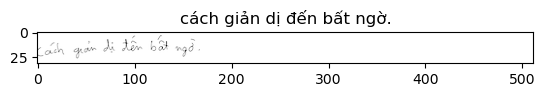

In [5]:
img, label = dataset[6]
plt.imshow(img[0], cmap='Grays')
plt.title(label)
plt.show()

In [ ]:
img

# Orther

In [12]:
class CheckImg:
    def __init__(self) -> None:
        self.imgW = 512
        self.imgH = 32
    
    def img_loader(self, path):
        img = Image.open(path).convert('L')
        img = img.point(lambda p: 255 - p) # chuyển background về màu đen 0

        # Cắt bỏ khoảng trống bị thừa xung quanh
        img_array = np.array(img)
        non_empty_columns = np.where(img_array.max(axis=0) > 0)[0]
        non_empty_rows = np.where(img_array.max(axis=1) > 0)[0]
        cropped_img = img_array[:, min(non_empty_columns):max(non_empty_columns) + 1]
        img = Image.fromarray(cropped_img)

        # # Resize hình ảnh + thêm padding (nếu cần)
        # desired_w, desired_h = self.imgW, self.imgH #(width, height)
        # img_w, img_h = img.size  # old_size[0] is in (width, height) format
        # ratio = 1.0*img_w/img_h
        # new_w = int(desired_h*ratio)
        # new_w = new_w if desired_w == None else min(desired_w, new_w)
        # img = img.resize((new_w, desired_h), Image.Resampling.LANCZOS)

        # # padding image
        # if desired_w != None and desired_w > new_w:
        #     new_img = Image.new("L", (desired_w, desired_h), color=0)
        #     new_img.paste(img, (0, 0))
        #     img = new_img
        
        return img.size

In [13]:
checkImg = CheckImg()

In [24]:
# Kiểm tra kích thước của ảnh để có thể resize về 512*32
ratio = 0
for path in os.listdir('data/img'):
    w, h = checkImg.img_loader('data/img/' + path )
    ratio = max(ratio, w/h)
    if w / h > 16:
        print(path)

In [23]:
ratio

13.696969696969697

# check utils

In [ ]:
!pip install python-levenshtein

In [1]:
class strLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            if not self.dict[char]: self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        else: #if isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)  
                
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts


In [9]:
import os
import torch

In [7]:
alphabet = open(os.path.join('data/char.txt')).read().rstrip()
nclass = len(alphabet) + 1
nc = 3

print(len(alphabet), alphabet)
converter = strLabelConverter(alphabet, ignore_case=True)

244  !"$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_abcdefghijklmnopqrstuvwxyz{|}°²ÀÁÂÃÈÉÊÌÍÐÒÓÔÕÖÙÚÜÝàáâãèéêìíðòóôõöùúüýĀāĂăĐđĨĩŌōŨũŪūƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ–—’“”…€™−


In [15]:
text, length = converter.encode(['HelLo cả nhà', 'xin chao'] )

In [17]:
converter.decode(text, length, raw = True)

['hello cả nhà', 'xin chao']